In [1]:
import os
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import sklearn
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import VarianceThreshold
from tensorflow.keras import layers,regularizers,Sequential,backend,callbacks,optimizers,metrics,losses
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import tensorflow.keras.backend as TFK
from sklearn.metrics import log_loss

/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [2]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(seed=42)

In [3]:
# Function to map an filter out control group
def mapping_and_filter(train, train_targets, test):
#     non_ctl_idxs = train['cp_type']!='ctl_vehicle'
    X_train = train.reset_index(drop=True)
    Y_train = train_targets.reset_index(drop=True)
    X_test = test.reset_index(drop=True)
    cp_mask = X_train['cp_type'] == 0
    cp_type = {'trt_cp': 0, 'ctl_vehicle': 1}
    cp_dose = {'D1': 0, 'D2': 1}
    for df in [X_train, X_test]:
        df['cp_type'] = df['cp_type'].map(cp_type)
        df['cp_dose'] = df['cp_dose'].map(cp_dose)
    X_train.drop(['sig_id'], inplace = True, axis = 1)
    Y_train.drop(['sig_id'], inplace = True, axis = 1)
    X_test.drop(['sig_id'], inplace = True, axis = 1)
    return X_train, Y_train, X_test

In [4]:
# Function to scale our data
def scaling(train, test):
    features = train.columns[2:]
    scaler = RobustScaler()
    scaler.fit(pd.concat([train[features], test[features]], axis = 0))
    train[features] = scaler.transform(train[features])
    test[features] = scaler.transform(test[features])
    return train, test, features

In [5]:

def mean_log_loss(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
    metrics = []
    for target in range(206):
        metrics.append(log_loss(y_true.loc[:, target], y_pred.loc[:, target]))
    return np.mean(metrics)

In [6]:
def create_model(num_inputs, num_outputs):
    f1_score = tfa.metrics.F1Score(num_classes=206, average='micro')
    model = tf.keras.Sequential([
    layers.Input(num_inputs),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    tfa.layers.WeightNormalization(tf.keras.layers.Dense(1024, activation="relu")),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    tfa.layers.WeightNormalization(tf.keras.layers.Dense(512, activation="relu")),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    tfa.layers.WeightNormalization(tf.keras.layers.Dense(num_outputs, activation="sigmoid"))
    ])
    model.compile(optimizer=tfa.optimizers.Lookahead(tf.optimizers.Adam(), sync_period=10),
                  loss=losses.BinaryCrossentropy(label_smoothing=0.001), metrics=[losses.BinaryCrossentropy(label_smoothing=0.001), f1_score])
    return model

In [7]:
def create_rnn_model(num_inputs, num_outputs):
    f1_score = tfa.metrics.F1Score(num_classes=206, average='micro')
    model = tf.keras.Sequential()
    model.add(layers.Input(num_inputs))
    model.add(layers.Reshape((1, num_inputs)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    model.add(tfa.layers.WeightNormalization(layers.LSTM(1024, dropout = 0.5, recurrent_dropout=0.4, return_sequences = True, activation='tanh')))
    model.add(tfa.layers.WeightNormalization(layers.LSTM(1024, dropout = 0.5, recurrent_dropout=0.5, activation='tanh')))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(tfa.layers.WeightNormalization(layers.Dense(num_outputs, activation='sigmoid', bias_initializer='zeros')))
    
    model.compile(optimizer = tfa.optimizers.Lookahead(tf.optimizers.Adam(0.0015), sync_period = 2), 
                  loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.001), 
                  metrics=[losses.BinaryCrossentropy(label_smoothing=0.001), f1_score])
    
    return model

In [8]:
def create_cnn_model(num_inputs, num_outputs):
    f1_score = tfa.metrics.F1Score(num_classes=206, average='micro')
    model = Sequential()
    model.add(layers.Input(shape=(num_inputs, 1)))
    model.add(tfa.layers.WeightNormalization(layers.Conv1D(filters=64, kernel_size=7)))
    model.add(layers.MaxPooling1D(5))
    model.add(tfa.layers.WeightNormalization(layers.Conv1D(filters=32, kernel_size=5)))
    model.add(layers.MaxPooling1D(5))
    model.add(tfa.layers.WeightNormalization(layers.Conv1D(filters=16, kernel_size=2)))
    model.add(layers.MaxPooling1D(5))
    model.add(layers.Flatten())
    
    
    # follow-up dense layers
    model.add(tfa.layers.WeightNormalization(layers.Dense(256, activation='elu', kernel_initializer='he_normal')))
    model.add(layers.Flatten())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.45))
    
    # output layer
    model.add(tfa.layers.WeightNormalization(layers.Dense(num_outputs, activation='sigmoid', bias_initializer='zeros')))
    
    model.compile(optimizer=tfa.optimizers.Lookahead(tf.optimizers.Adam(lr=0.00005), sync_period = 2), 
                  loss= tf.keras.losses.BinaryCrossentropy(label_smoothing=0.001), 
                  metrics=[losses.BinaryCrossentropy(label_smoothing=0.001), f1_score])
    
    return model

In [9]:
def conv1d_preprocess(data):
    processed = data.astype('float32')
    processed = processed.reshape(data.shape[0], data.shape[1], 1)
    return processed

In [10]:
def train_model(X, Y, classifier):
    strat_kfold = KFold(n_splits=5, shuffle=True)
    for train_index, val_index in strat_kfold.split(X, Y):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = Y[train_index], Y[val_index]
        model = classifier.fit(x=X_train, y=y_train, 
                               batch_size=32, epochs=50,
                               validation_data=(X_val, y_val),
                               verbose=1)
    return model

In [11]:
def get_pca_transform(features_data, ):
    pca_t = PCA(n_components=406)
#     pca_t = PCA(0.95)
    pca_data = pca_t.fit_transform(features_data)
    print(pca_t.explained_variance_ratio_.cumsum())
    return pca_data

In [12]:
def plot_history_results(history, metric="f1_score", figsize=(16,6)):
    """ Helper function for plotting history from keras model """
    
    # gather desired features
    trg_loss = history.history['loss']
    val_loss = history.history['val_loss']
    trg_acc = history.history[f'{metric}']
    val_acc = history.history[f'val_{metric}']
    epochs = range(1, len(trg_acc) + 1)

    # plot losses and accuracies for training and validation 
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1, 2, 1)
    plt.plot(epochs, trg_loss, marker='o', label='Training Loss')
    plt.plot(epochs, val_loss, marker='x', label='Validation Loss')
    plt.title("Training / Validation Loss")
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epochs")
    plt.legend(loc='best')

    ax = fig.add_subplot(1, 2, 2)
    plt.plot(epochs, trg_acc, marker='o', label=f'Training {metric}')
    plt.plot(epochs, val_acc, marker='^', label=f'Validation {metric}')
    plt.title(f"Training / Validation {metric}")
    ax.set_ylabel(f"{metric}")
    ax.set_xlabel("Epochs")
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

In [13]:
# Import train data
train_features = pd.read_csv(r'../input/lish-moa/train_features.csv')
train_targets_scored = pd.read_csv(r'../input/lish-moa/train_targets_scored.csv')

# Import test data
test_features = pd.read_csv(r'../input/lish-moa/test_features.csv')
submis = pd.read_csv('../input/lish-moa/sample_submission.csv')
print(train_features.shape, train_targets_scored.shape, test_features.shape)

(23814, 876) (23814, 207) (3982, 876)


In [14]:
X_train, Y_train, X_test = mapping_and_filter(train_features, train_targets_scored, test_features)

In [15]:
# train_features.shape, train_targets_scored.shape
X_train.shape, Y_train.shape, X_test.shape

((23814, 875), (23814, 206), (3982, 875))

In [16]:
for col in X_test.columns:
    if isinstance(X_test[col][10], str):
        print(col, X_test[col][10])

In [17]:
# Min Max Scaler for numerical values

# Fit scaler to joint train and test data
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train.append(X_test))

# Scale train data
data_train = scaler.transform(X_train)

# Scale test data
data_test = scaler.transform(X_test)

In [18]:
data_train.shape[1]

875

In [19]:
classifier_outputs = len(Y_train.columns)
classifier_inputs = data_train.shape[1]
rows_train = data_train.shape[0]
rows_test = data_test.shape[0]

In [20]:
pca_x_train = get_pca_transform(data_train)

[0.41559392 0.45655117 0.4913385  0.51667992 0.53652447 0.55485139
 0.57176965 0.58700402 0.59986533 0.61147387 0.62143407 0.62978959
 0.63710557 0.64390679 0.65036317 0.65592648 0.66099618 0.66592291
 0.67059176 0.67501538 0.67898886 0.68273178 0.68636731 0.68974793
 0.69285757 0.69576514 0.69853114 0.70115829 0.70374732 0.70617014
 0.70853157 0.71079736 0.71299171 0.7151219  0.71714853 0.7191018
 0.72097017 0.72280187 0.72460904 0.72634412 0.7280528  0.729657
 0.73120405 0.73272218 0.73419817 0.73563488 0.73705848 0.73847015
 0.739848   0.74121014 0.74254193 0.74383362 0.74512108 0.74636848
 0.74759639 0.74880354 0.74998622 0.75116331 0.75231432 0.75346368
 0.75460875 0.75574053 0.75684944 0.75794557 0.75902596 0.76009992
 0.76115443 0.76220317 0.76323712 0.76425863 0.76526354 0.76626351
 0.76725757 0.76824164 0.76921757 0.77018318 0.77113956 0.77209023
 0.77302832 0.77396021 0.77488947 0.77580999 0.77672301 0.77763068
 0.77852612 0.77941305 0.78029501 0.78116982 0.7820428  0.7829096

In [21]:
pca_x_train.shape

(23814, 406)

In [22]:
moa_classifier = create_model(pca_x_train.shape[1], classifier_outputs)

In [23]:
moa_rnn = create_rnn_model(pca_x_train.shape[1], classifier_outputs)

In [24]:
moa_cnn = create_cnn_model(pca_x_train.shape[1], classifier_outputs)

In [25]:
f_model = train_model(pca_x_train, Y_train.values, moa_classifier)

Epoch 1/50
596/596 [==============================] - 6s 11ms/step - loss: 0.2534 - binary_crossentropy: 0.2532 - f1_score: 0.0303 - val_loss: 0.0315 - val_binary_crossentropy: 0.0315 - val_f1_score: 0.0869
Epoch 2/50
596/596 [==============================] - 5s 8ms/step - loss: 0.0266 - binary_crossentropy: 0.0266 - f1_score: 0.0897 - val_loss: 0.0224 - val_binary_crossentropy: 0.0224 - val_f1_score: 0.1303
Epoch 3/50
596/596 [==============================] - 5s 8ms/step - loss: 0.0229 - binary_crossentropy: 0.0229 - f1_score: 0.1196 - val_loss: 0.0209 - val_binary_crossentropy: 0.0209 - val_f1_score: 0.1544
Epoch 4/50
596/596 [==============================] - 5s 8ms/step - loss: 0.0217 - binary_crossentropy: 0.0217 - f1_score: 0.1395 - val_loss: 0.0201 - val_binary_crossentropy: 0.0201 - val_f1_score: 0.1670
Epoch 5/50
596/596 [==============================] - 5s 9ms/step - loss: 0.0209 - binary_crossentropy: 0.0209 - f1_score: 0.1561 - val_loss: 0.0197 - val_binary_crossentropy:

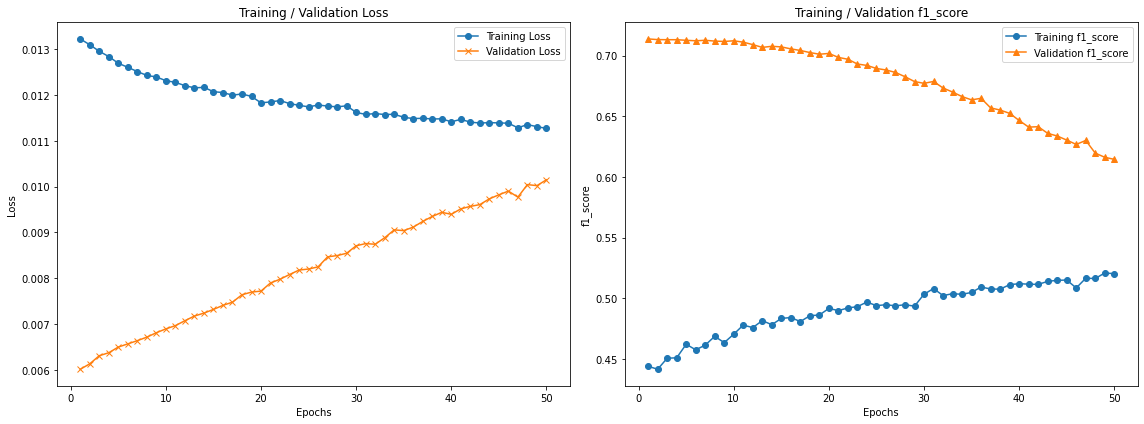

In [26]:
plot_history_results(f_model)

In [27]:
rnn_model = train_model(pca_x_train, Y_train.values, moa_rnn)

Epoch 1/50
596/596 [==============================] - 17s 29ms/step - loss: 0.1562 - binary_crossentropy: 0.1561 - f1_score: 0.0269 - val_loss: 0.0234 - val_binary_crossentropy: 0.0234 - val_f1_score: 0.0654
Epoch 2/50
596/596 [==============================] - 16s 27ms/step - loss: 0.0241 - binary_crossentropy: 0.0241 - f1_score: 0.0804 - val_loss: 0.0215 - val_binary_crossentropy: 0.0215 - val_f1_score: 0.1396
Epoch 3/50
596/596 [==============================] - 16s 27ms/step - loss: 0.0232 - binary_crossentropy: 0.0232 - f1_score: 0.1037 - val_loss: 0.0205 - val_binary_crossentropy: 0.0205 - val_f1_score: 0.1571
Epoch 4/50
596/596 [==============================] - 15s 25ms/step - loss: 0.0226 - binary_crossentropy: 0.0226 - f1_score: 0.1205 - val_loss: 0.0201 - val_binary_crossentropy: 0.0201 - val_f1_score: 0.1689
Epoch 5/50
596/596 [==============================] - 16s 27ms/step - loss: 0.0221 - binary_crossentropy: 0.0221 - f1_score: 0.1320 - val_loss: 0.0198 - val_binary_cros

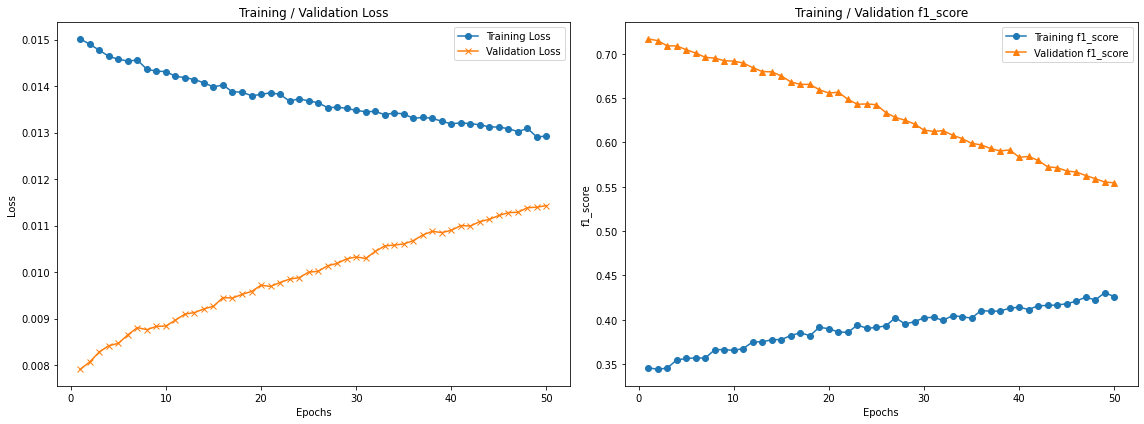

In [28]:
plot_history_results(rnn_model)

In [29]:
cnn_xtrain = conv1d_preprocess(pca_x_train)
cnn_model = train_model(cnn_xtrain, Y_train.values, moa_cnn)

Epoch 1/50
596/596 [==============================] - 6s 10ms/step - loss: 0.7683 - binary_crossentropy: 0.7683 - f1_score: 0.0053 - val_loss: 0.6920 - val_binary_crossentropy: 0.6920 - val_f1_score: 0.0259
Epoch 2/50
596/596 [==============================] - 5s 9ms/step - loss: 0.7322 - binary_crossentropy: 0.7322 - f1_score: 0.0093 - val_loss: 0.6680 - val_binary_crossentropy: 0.6680 - val_f1_score: 0.0426
Epoch 3/50
596/596 [==============================] - 5s 9ms/step - loss: 0.7004 - binary_crossentropy: 0.7003 - f1_score: 0.0128 - val_loss: 0.6355 - val_binary_crossentropy: 0.6355 - val_f1_score: 0.0436
Epoch 4/50
596/596 [==============================] - 5s 9ms/step - loss: 0.6583 - binary_crossentropy: 0.6583 - f1_score: 0.0143 - val_loss: 0.5964 - val_binary_crossentropy: 0.5964 - val_f1_score: 0.0429
Epoch 5/50
596/596 [==============================] - 6s 10ms/step - loss: 0.6008 - binary_crossentropy: 0.6008 - f1_score: 0.0150 - val_loss: 0.5297 - val_binary_crossentropy

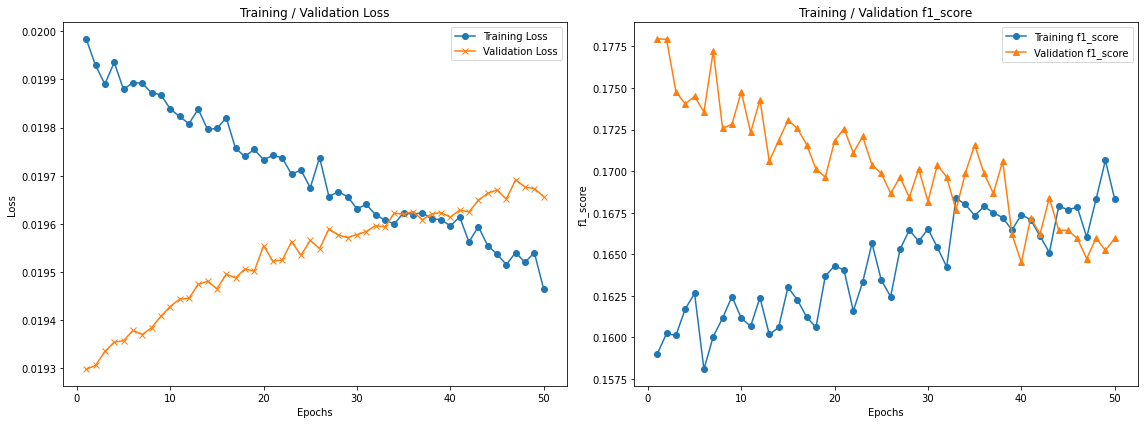

In [30]:
plot_history_results(cnn_model)

In [31]:
Y_preds = moa_classifier.predict(pca_x_train)
cols = [i for i in range(Y_preds.shape[1])]
ref_preds = pd.DataFrame(data=Y_train.values, columns=cols)
Y_preds = pd.DataFrame(data=Y_preds, columns=cols)
print(mean_log_loss(ref_preds, Y_preds))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:2240: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:2240: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:2240: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:2240: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:2240: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/opt/conda/lib/python3.7/site-packages/skl

nan


In [32]:
pca_x_test = get_pca_transform(data_test)

[0.42690576 0.46888005 0.50229652 0.52668641 0.54727552 0.56600054
 0.58295983 0.59714792 0.60971067 0.6205371  0.63070559 0.63953003
 0.64649172 0.65309269 0.65921647 0.66489953 0.67029284 0.67547199
 0.67999229 0.68420327 0.68825317 0.69202372 0.69567593 0.69906049
 0.70223424 0.70524555 0.70816608 0.7107976  0.71334589 0.7158712
 0.71819584 0.72041263 0.72256811 0.72463964 0.72664143 0.72859723
 0.7304742  0.7323129  0.73410897 0.73585287 0.73753376 0.73918994
 0.7408444  0.7424456  0.74401354 0.74551976 0.7469942  0.7484516
 0.74990256 0.7513142  0.75271288 0.7540879  0.75544289 0.7567799
 0.75810181 0.75936614 0.76061248 0.76184652 0.76306949 0.76428409
 0.7654723  0.76664593 0.76781622 0.76896715 0.77010901 0.77124833
 0.77237098 0.77348536 0.77458334 0.77567576 0.77674963 0.77781956
 0.77887702 0.77992238 0.78095801 0.78198842 0.78301315 0.78403136
 0.78504546 0.78604951 0.7870418  0.78803098 0.7890024  0.78996971
 0.79092939 0.79187957 0.7928224  0.79376264 0.79469683 0.795622


In [33]:
pca_x_test.shape

(3982, 406)

In [34]:
test_preds = moa_classifier.predict(pca_x_test)

In [35]:
control_mask = X_test['cp_type']==1
np.where(control_mask == True)[0]

array([   2,    5,   26,   63,   84,   89,   90,   91,  110,  113,  133,
        139,  150,  182,  196,  202,  211,  215,  224,  225,  237,  242,
        260,  263,  305,  309,  320,  322,  347,  368,  370,  384,  394,
        418,  430,  464,  465,  469,  488,  510,  512,  514,  532,  538,
        541,  545,  566,  573,  574,  638,  639,  640,  647,  650,  667,
        669,  688,  703,  711,  723,  739,  759,  761,  763,  769,  770,
        777,  782,  785,  796,  828,  829,  845,  859,  860,  871,  878,
        879,  916,  932,  933,  950,  962,  963, 1006, 1008, 1009, 1035,
       1036, 1071, 1082, 1113, 1124, 1130, 1144, 1149, 1150, 1164, 1167,
       1182, 1184, 1189, 1217, 1232, 1251, 1263, 1264, 1268, 1280, 1295,
       1297, 1306, 1324, 1352, 1359, 1384, 1385, 1393, 1400, 1402, 1417,
       1420, 1423, 1424, 1431, 1437, 1471, 1473, 1474, 1492, 1495, 1511,
       1522, 1525, 1528, 1557, 1560, 1565, 1593, 1595, 1611, 1617, 1639,
       1644, 1672, 1674, 1688, 1700, 1711, 1712, 17

In [36]:
test_preds[control_mask] = 0

In [37]:
test_preds.shape

(3982, 206)

In [38]:
submis.loc[:, Y_train.columns] = test_preds

In [39]:
submis.loc[control_mask, Y_train.columns] = 0

In [40]:
submis.to_csv('submission.csv', index=False)